In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

# Đọc dữ liệu vào

In [2]:
data = pd.read_csv('/kaggle/input/gia-nha/gia_nha.csv')
data.head()

,DiaChi,TinhTrangBDS,DienTich,Gia/m2,Phongngu,TenPhanKhu,SoTang,PhongTam,Loai,GiayTo,MaCanHo,TinhTrangNoiThat,HuongCuaChinh,HuongBanCong,DacDiem,Gia
0,"Đường Nguyễn Văn Quỳ, Phường Phú Thuận, Quận 7...",Đã bàn giao,62 m²,"32,26 triệu/m²",2 phòng,NaN,NaN,2 phòng,Chung cư,Đã có sổ,NaN,NaN,NaN,NaN,NaN,2 tỷ- 62 m2đ
1,"Đường Nguyễn Văn Linh, Phường Tân Thuận Tây, Q...",Đã bàn giao,95 m²,"55,79 triệu/m²",3 phòng,NaN,NaN,2 phòng,Chung cư,Đang chờ sổ,NaN,Nội thất cao cấp,NaN,NaN,Căn góc,"5,3 tỷ- 95 m2đ"
2,"Đường Võ Văn Kiệt, Phường An Lạc, Quận Bình Tâ...",Chưa bàn giao,75 m²,"34,4 triệu/m²",2 phòng,2,5.0,2 phòng,Chung cư,Giấy tờ khác,17,NaN,Đông Nam,Đông Nam,NaN,"2,58 tỷ- 75 m2đ"
3,"108, Đường Hồng Hà, Phường 2, Quận Tân Bình, T...",Đã bàn giao,70 m²,"57,14 triệu/m²",1 phòng,A,7.0,1 phòng,Chung cư,Đang chờ sổ,BPA - 0712,Nội thất cao cấp,Đông Nam,Tây Bắc,NaN,4 tỷ- 70 m2đ
4,"Đường Hậu Giang, Phường 11, Quận 6, Tp Hồ Chí ...",Đã bàn giao,83 m²,"35,54 triệu/m²",2 phòng,NaN,NaN,2 phòng,Chung cư,Đã có sổ,NaN,Nội thất cao cấp,Tây Bắc,NaN,NaN,"2,95 tỷ- 83 m2đ"


In [3]:
data['DienTich'] = data['DienTich'].str.replace(r'[^\d.]', '', regex=True).astype(float)
data['Gia/m2'] = data['Gia/m2'].str.replace(r'[^\d.]', '', regex=True).astype(float)
data['Phongngu'] = data['Phongngu'].str.replace(r'[^\d.]', '', regex=True).astype(float)
data['PhongTam'] = data['PhongTam'].str.replace(r'[^\d.]', '', regex=True).astype(float)

def extract_district(address):
    parts = address.split(',')
    for part in parts:
        part = part.strip()
        if part.startswith('Quận ') or part.startswith('Huyện '):
            if part[-1] == '.':
                return part[:-1]
            else:
                return part
    return None

data['DiaChi'] = data['DiaChi'].apply(extract_district)

In [4]:
data['DiaChi'].unique()

array(['Quận 7', 'Quận Bình Tân', 'Quận Tân Bình', 'Quận 6', 'Quận 8',
       'Quận Bình Thạnh', 'Huyện Bình Chánh', 'Huyện Hóc Môn',
       'Quận Thủ Đức', 'Quận 9', 'Quận 10', 'Huyện Nhà Bè', 'Quận 12',
       'Quận Tân Phú', 'Quận 2', None, 'Quận Phú Nhuận', 'Quận 1',
       'Quận 4', 'Quận 11', 'Quận 5', 'Quận Gò Vấp', 'Quận 3',
       'Huyện Củ Chi'], dtype=object)

In [5]:
data.head()

,DiaChi,TinhTrangBDS,DienTich,Gia/m2,Phongngu,TenPhanKhu,SoTang,PhongTam,Loai,GiayTo,MaCanHo,TinhTrangNoiThat,HuongCuaChinh,HuongBanCong,DacDiem,Gia
0,Quận 7,Đã bàn giao,62.0,3226.0,2.0,NaN,NaN,2.0,Chung cư,Đã có sổ,NaN,NaN,NaN,NaN,NaN,2 tỷ- 62 m2đ
1,Quận 7,Đã bàn giao,95.0,5579.0,3.0,NaN,NaN,2.0,Chung cư,Đang chờ sổ,NaN,Nội thất cao cấp,NaN,NaN,Căn góc,"5,3 tỷ- 95 m2đ"
2,Quận Bình Tân,Chưa bàn giao,75.0,344.0,2.0,2,5.0,2.0,Chung cư,Giấy tờ khác,17,NaN,Đông Nam,Đông Nam,NaN,"2,58 tỷ- 75 m2đ"
3,Quận Tân Bình,Đã bàn giao,70.0,5714.0,1.0,A,7.0,1.0,Chung cư,Đang chờ sổ,BPA - 0712,Nội thất cao cấp,Đông Nam,Tây Bắc,NaN,4 tỷ- 70 m2đ
4,Quận 6,Đã bàn giao,83.0,3554.0,2.0,NaN,NaN,2.0,Chung cư,Đã có sổ,NaN,Nội thất cao cấp,Tây Bắc,NaN,NaN,"2,95 tỷ- 83 m2đ"


In [6]:
def convert_gia(value):
    value = value.lower()
    if 'tỷ' in value:
        result = re.search(r'(\d+,\d+|\d+)', value)
        if result:
            return float(result.group(0).replace(',', '.'))
    elif 'triệu' in value:
        result = re.search(r'(\d+,\d+|\d+)', value)
        if result:
            return float(result.group(0).replace(',', '.')) / 1000
    return 0

data['Gia'] = data['Gia'].apply(convert_gia)
data.head()

,DiaChi,TinhTrangBDS,DienTich,Gia/m2,Phongngu,TenPhanKhu,SoTang,PhongTam,Loai,GiayTo,MaCanHo,TinhTrangNoiThat,HuongCuaChinh,HuongBanCong,DacDiem,Gia
0,Quận 7,Đã bàn giao,62.0,3226.0,2.0,NaN,NaN,2.0,Chung cư,Đã có sổ,NaN,NaN,NaN,NaN,NaN,2.00
1,Quận 7,Đã bàn giao,95.0,5579.0,3.0,NaN,NaN,2.0,Chung cư,Đang chờ sổ,NaN,Nội thất cao cấp,NaN,NaN,Căn góc,5.30
2,Quận Bình Tân,Chưa bàn giao,75.0,344.0,2.0,2,5.0,2.0,Chung cư,Giấy tờ khác,17,NaN,Đông Nam,Đông Nam,NaN,2.58
3,Quận Tân Bình,Đã bàn giao,70.0,5714.0,1.0,A,7.0,1.0,Chung cư,Đang chờ sổ,BPA - 0712,Nội thất cao cấp,Đông Nam,Tây Bắc,NaN,4.00
4,Quận 6,Đã bàn giao,83.0,3554.0,2.0,NaN,NaN,2.0,Chung cư,Đã có sổ,NaN,Nội thất cao cấp,Tây Bắc,NaN,NaN,2.95


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24949 entries, 0 to 24948
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DiaChi            24624 non-null  object 
 1   TinhTrangBDS      24924 non-null  object 
 2   DienTich          24917 non-null  float64
 3   Gia/m2            24916 non-null  float64
 4   Phongngu          24926 non-null  float64
 5   TenPhanKhu        7036 non-null   object 
 6   SoTang            6726 non-null   float64
 7   PhongTam          24388 non-null  float64
 8   Loai              24926 non-null  object 
 9   GiayTo            18852 non-null  object 
 10  MaCanHo           3358 non-null   object 
 11  TinhTrangNoiThat  12790 non-null  object 
 12  HuongCuaChinh     9370 non-null   object 
 13  HuongBanCong      8670 non-null   object 
 14  DacDiem           5601 non-null   object 
 15  Gia               24949 non-null  float64
dtypes: float64(6), object(10)
memory usage: 

In [8]:
data.describe()

,DienTich,Gia/m2,Phongngu,SoTang,PhongTam,Gia
count,24917.000000,2.491600e+04,24926.000000,6726.000000,24388.000000,24949.000000
mean,193.907179,6.803146e+06,2.045134,11.482307,1.750656,2.865201
std,7465.948823,5.424467e+08,0.730980,18.142728,0.596897,7.827805
min,1.000000,0.000000e+00,1.000000,1.000000,1.000000,0.000000
25%,56.000000,1.412000e+03,2.000000,5.000000,1.000000,1.600000
50%,68.000000,2.973500e+03,2.000000,9.000000,2.000000,2.250000
75%,80.000000,4.151000e+03,2.000000,16.000000,2.000000,3.300000
max,780000.000000,5.428571e+10,10.000000,789.000000,6.000000,980.000000


In [9]:
import seaborn as sns

# Xử lý giá trị Null

In [10]:
data.isnull().mean()*100

DiaChi               1.302657
TinhTrangBDS         0.100204
DienTich             0.128262
Gia/m2               0.132270
Phongngu             0.092188
TenPhanKhu          71.798469
SoTang              73.041004
PhongTam             2.248587
Loai                 0.092188
GiayTo              24.437853
MaCanHo             86.540543
TinhTrangNoiThat    48.735420
HuongCuaChinh       62.443385
HuongBanCong        65.249108
DacDiem             77.550202
Gia                  0.000000
dtype: float64

In [11]:
cols_to_drop = ['TenPhanKhu', 'SoTang', 'MaCanHo', 'HuongCuaChinh', 'HuongBanCong', 'DacDiem']
data = data.drop(columns=cols_to_drop)
data.head()

,DiaChi,TinhTrangBDS,DienTich,Gia/m2,Phongngu,PhongTam,Loai,GiayTo,TinhTrangNoiThat,Gia
0,Quận 7,Đã bàn giao,62.0,3226.0,2.0,2.0,Chung cư,Đã có sổ,NaN,2.00
1,Quận 7,Đã bàn giao,95.0,5579.0,3.0,2.0,Chung cư,Đang chờ sổ,Nội thất cao cấp,5.30
2,Quận Bình Tân,Chưa bàn giao,75.0,344.0,2.0,2.0,Chung cư,Giấy tờ khác,NaN,2.58
3,Quận Tân Bình,Đã bàn giao,70.0,5714.0,1.0,1.0,Chung cư,Đang chờ sổ,Nội thất cao cấp,4.00
4,Quận 6,Đã bàn giao,83.0,3554.0,2.0,2.0,Chung cư,Đã có sổ,Nội thất cao cấp,2.95


In [12]:
columns_to_check = ['DiaChi','TinhTrangBDS', 'DienTich', 'Gia/m2', 'Phongngu', 'PhongTam', 'Loai']
data = data.dropna(subset=columns_to_check)

In [13]:
data.isnull().mean()*100

DiaChi               0.000000
TinhTrangBDS         0.000000
DienTich             0.000000
Gia/m2               0.000000
Phongngu             0.000000
PhongTam             0.000000
Loai                 0.000000
GiayTo              23.881093
TinhTrangNoiThat    48.252097
Gia                  0.000000
dtype: float64

In [14]:
data.head(10)

,DiaChi,TinhTrangBDS,DienTich,Gia/m2,Phongngu,PhongTam,Loai,GiayTo,TinhTrangNoiThat,Gia
0,Quận 7,Đã bàn giao,62.0,3226.0,2.0,2.0,Chung cư,Đã có sổ,NaN,2.00
1,Quận 7,Đã bàn giao,95.0,5579.0,3.0,2.0,Chung cư,Đang chờ sổ,Nội thất cao cấp,5.30
2,Quận Bình Tân,Chưa bàn giao,75.0,344.0,2.0,2.0,Chung cư,Giấy tờ khác,NaN,2.58
3,Quận Tân Bình,Đã bàn giao,70.0,5714.0,1.0,1.0,Chung cư,Đang chờ sổ,Nội thất cao cấp,4.00
4,Quận 6,Đã bàn giao,83.0,3554.0,2.0,2.0,Chung cư,Đã có sổ,Nội thất cao cấp,2.95
5,Quận 8,Đã bàn giao,71.0,2789.0,2.0,1.0,Chung cư,Đang chờ sổ,NaN,1.98
6,Quận Bình Thạnh,Đã bàn giao,71.0,3831.0,2.0,2.0,Chung cư,Đang chờ sổ,NaN,2.72
7,Huyện Bình Chánh,Đã bàn giao,78.0,3321.0,2.0,2.0,Chung cư,Đang chờ sổ,NaN,2.59
8,Quận Bình Tân,Đã bàn giao,50.0,278.0,1.0,1.0,Chung cư,Đã có sổ,Hoàn thiện cơ bản,1.39
9,Huyện Hóc Môn,Đã bàn giao,40.0,375.0,1.0,1.0,Chung cư,Đã có sổ,NaN,0.15


In [15]:
from sklearn.impute import SimpleImputer

columns_to_impute = ['GiayTo', 'TinhTrangNoiThat']
mode_imputer = SimpleImputer(strategy='most_frequent')
for column in columns_to_impute:
    data[column] = mode_imputer.fit_transform(data[[column]]).ravel()

data.head()

,DiaChi,TinhTrangBDS,DienTich,Gia/m2,Phongngu,PhongTam,Loai,GiayTo,TinhTrangNoiThat,Gia
0,Quận 7,Đã bàn giao,62.0,3226.0,2.0,2.0,Chung cư,Đã có sổ,Hoàn thiện cơ bản,2.00
1,Quận 7,Đã bàn giao,95.0,5579.0,3.0,2.0,Chung cư,Đang chờ sổ,Nội thất cao cấp,5.30
2,Quận Bình Tân,Chưa bàn giao,75.0,344.0,2.0,2.0,Chung cư,Giấy tờ khác,Hoàn thiện cơ bản,2.58
3,Quận Tân Bình,Đã bàn giao,70.0,5714.0,1.0,1.0,Chung cư,Đang chờ sổ,Nội thất cao cấp,4.00
4,Quận 6,Đã bàn giao,83.0,3554.0,2.0,2.0,Chung cư,Đã có sổ,Nội thất cao cấp,2.95


In [16]:
data.isna().sum()

DiaChi              0
TinhTrangBDS        0
DienTich            0
Gia/m2              0
Phongngu            0
PhongTam            0
Loai                0
GiayTo              0
TinhTrangNoiThat    0
Gia                 0
dtype: int64

# Xử lý giá trị trùng

In [17]:
duplicate = data[data.duplicated()]
print(f"Number of duplicate rows: {len(duplicate)}")
duplicate.head()

Number of duplicate rows: 7358


,DiaChi,TinhTrangBDS,DienTich,Gia/m2,Phongngu,PhongTam,Loai,GiayTo,TinhTrangNoiThat,Gia
25,Quận 6,Đã bàn giao,83.0,3554.0,2.0,2.0,Chung cư,Đã có sổ,Nội thất cao cấp,2.95
29,Quận 7,Đã bàn giao,95.0,5579.0,3.0,2.0,Chung cư,Đang chờ sổ,Nội thất cao cấp,5.30
51,Quận 6,Đã bàn giao,83.0,3554.0,2.0,2.0,Chung cư,Đã có sổ,Nội thất cao cấp,2.95
53,Quận 7,Đã bàn giao,62.0,3226.0,2.0,2.0,Chung cư,Đã có sổ,Hoàn thiện cơ bản,2.00
75,Quận 8,Đã bàn giao,65.0,2769.0,2.0,1.0,Chung cư,Đã có sổ,Hoàn thiện cơ bản,1.80


In [18]:
data = data.drop_duplicates()

In [19]:
duplicate = data[data.duplicated()]
duplicate

,DiaChi,TinhTrangBDS,DienTich,Gia/m2,Phongngu,PhongTam,Loai,GiayTo,TinhTrangNoiThat,Gia


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16728 entries, 0 to 24948
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DiaChi            16728 non-null  object 
 1   TinhTrangBDS      16728 non-null  object 
 2   DienTich          16728 non-null  float64
 3   Gia/m2            16728 non-null  float64
 4   Phongngu          16728 non-null  float64
 5   PhongTam          16728 non-null  float64
 6   Loai              16728 non-null  object 
 7   GiayTo            16728 non-null  object 
 8   TinhTrangNoiThat  16728 non-null  object 
 9   Gia               16728 non-null  float64
dtypes: float64(5), object(5)
memory usage: 1.4+ MB


# Xử lý ngoại lệ

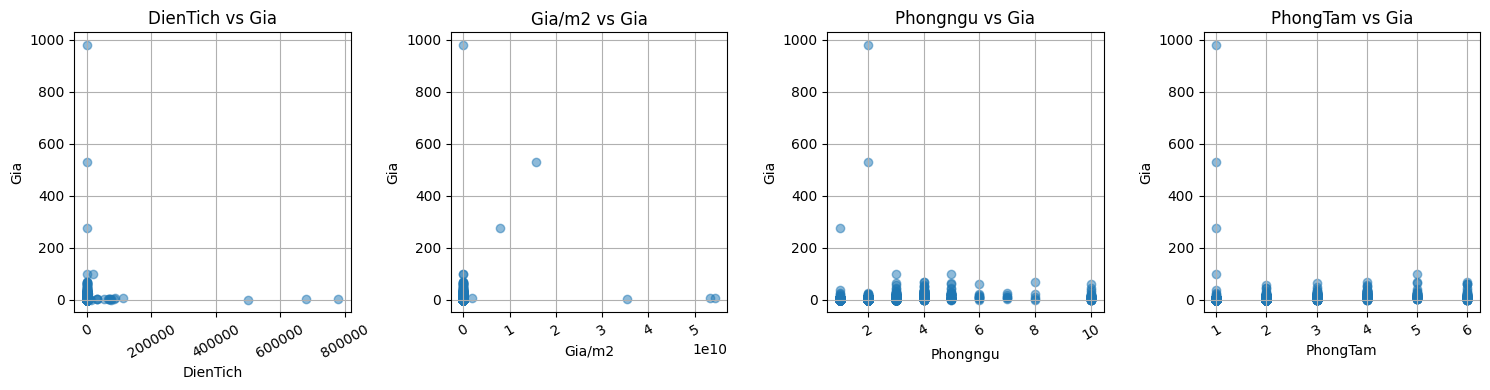

In [21]:
numeric_columns = ['DienTich', 'Gia/m2', 'Phongngu', 'PhongTam']

plt.figure(figsize = (15,4))
for i, col in enumerate(numeric_columns):
    plt.subplot(1, 4, i + 1)
    plt.scatter(data[col], data['Gia'], alpha=0.5)
    plt.title(f'{col} vs Gia')
    plt.xlabel(col)
    plt.ylabel('Gia')
    plt.xticks(rotation=30)
    plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
data.describe()

,DienTich,Gia/m2,Phongngu,PhongTam,Gia
count,16728.000000,1.672800e+04,16728.000000,16728.000000,16728.000000
mean,247.410618,1.005541e+07,2.047824,1.737626,2.885566
std,9097.838107,6.619334e+08,0.792660,0.640936,9.391510
min,1.000000,1.000000e+00,1.000000,1.000000,0.001000
25%,55.000000,1.367750e+03,2.000000,1.000000,1.600000
50%,68.000000,3.092000e+03,2.000000,2.000000,2.250000
75%,80.000000,4.191000e+03,2.000000,2.000000,3.250000
max,780000.000000,5.428571e+10,10.000000,6.000000,980.000000


In [23]:
data.head()

,DiaChi,TinhTrangBDS,DienTich,Gia/m2,Phongngu,PhongTam,Loai,GiayTo,TinhTrangNoiThat,Gia
0,Quận 7,Đã bàn giao,62.0,3226.0,2.0,2.0,Chung cư,Đã có sổ,Hoàn thiện cơ bản,2.00
1,Quận 7,Đã bàn giao,95.0,5579.0,3.0,2.0,Chung cư,Đang chờ sổ,Nội thất cao cấp,5.30
2,Quận Bình Tân,Chưa bàn giao,75.0,344.0,2.0,2.0,Chung cư,Giấy tờ khác,Hoàn thiện cơ bản,2.58
3,Quận Tân Bình,Đã bàn giao,70.0,5714.0,1.0,1.0,Chung cư,Đang chờ sổ,Nội thất cao cấp,4.00
4,Quận 6,Đã bàn giao,83.0,3554.0,2.0,2.0,Chung cư,Đã có sổ,Nội thất cao cấp,2.95


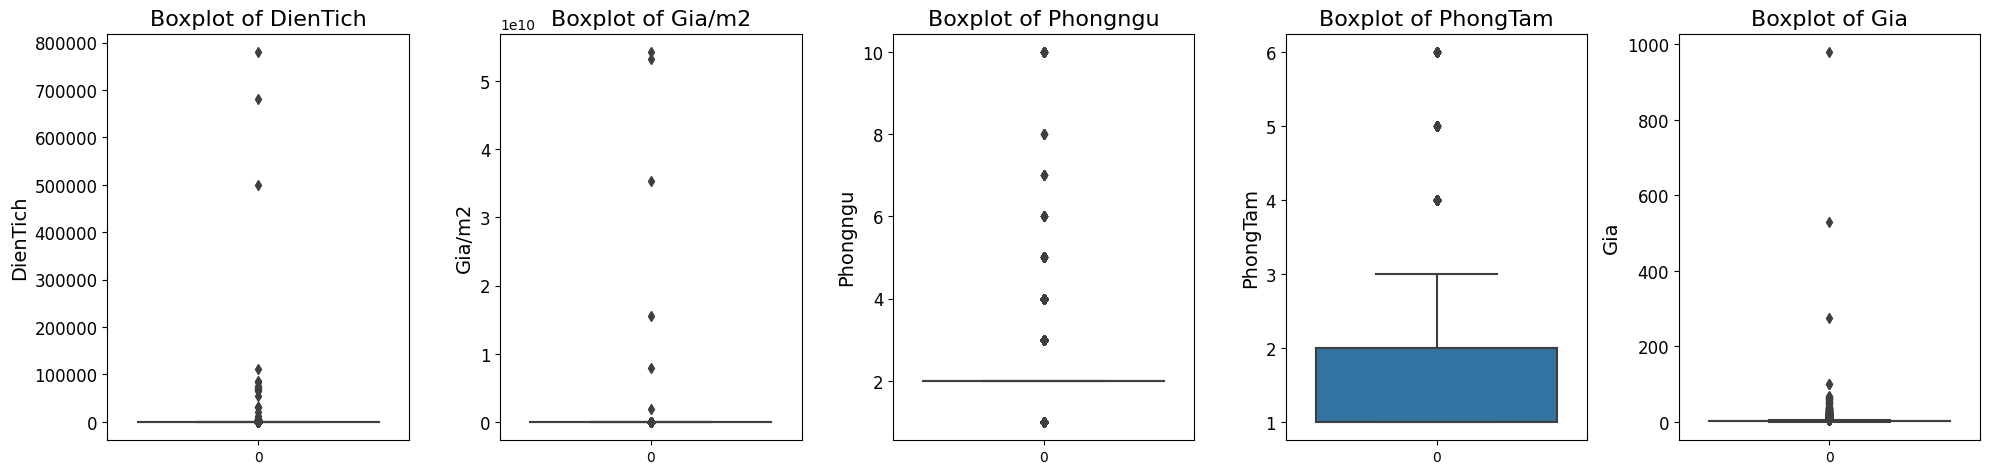

In [24]:
numeric_cols = ['DienTich', 'Gia/m2', 'Phongngu', 'PhongTam', 'Gia']
plt.figure(figsize=(20, 5))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, len(numeric_cols), i)
    sns.boxplot(data=data[col])
    plt.title(f'Boxplot of {col}', fontsize=16)
    plt.yticks(fontsize = 12)
    plt.ylabel(col, fontsize=14)

plt.tight_layout()
plt.show()

In [25]:
numeric_cols = ['DienTich', 'Gia/m2', 'Phongngu', 'PhongTam', 'Gia']


def handle_outliers(df, col):
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    lower_limit = df[col].quantile(0.25) - (IQR * 1.5)
    upper_limit = df[col].quantile(0.75) + (IQR * 1.5)

    df.loc[df[col] > upper_limit, col] = upper_limit
    df.loc[df[col] < lower_limit, col] = lower_limit

# Chạy vòng lặp qua các cột số và xử lý ngoại lệ
for col in numeric_cols:
    handle_outliers(data, col)

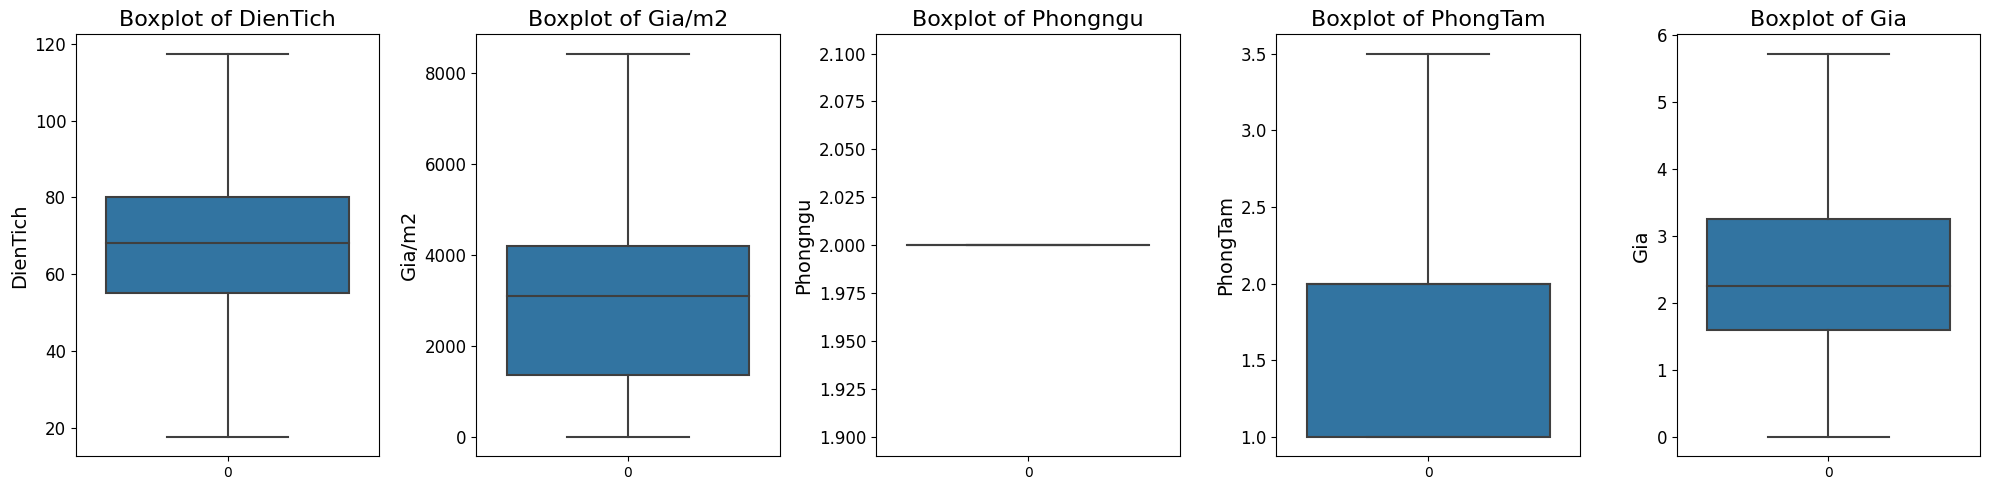

In [26]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, len(numeric_cols), i)
    sns.boxplot(data=data[col])
    plt.title(f'Boxplot of {col}', fontsize=16)
    plt.yticks(fontsize = 12)
    plt.ylabel(col, fontsize=14)

plt.tight_layout()
plt.show()

In [27]:
data.drop(columns='Phongngu', inplace = True)
data.head()

,DiaChi,TinhTrangBDS,DienTich,Gia/m2,PhongTam,Loai,GiayTo,TinhTrangNoiThat,Gia
0,Quận 7,Đã bàn giao,62.0,3226.0,2.0,Chung cư,Đã có sổ,Hoàn thiện cơ bản,2.00
1,Quận 7,Đã bàn giao,95.0,5579.0,2.0,Chung cư,Đang chờ sổ,Nội thất cao cấp,5.30
2,Quận Bình Tân,Chưa bàn giao,75.0,344.0,2.0,Chung cư,Giấy tờ khác,Hoàn thiện cơ bản,2.58
3,Quận Tân Bình,Đã bàn giao,70.0,5714.0,1.0,Chung cư,Đang chờ sổ,Nội thất cao cấp,4.00
4,Quận 6,Đã bàn giao,83.0,3554.0,2.0,Chung cư,Đã có sổ,Nội thất cao cấp,2.95


# Trực quan dữ liệu

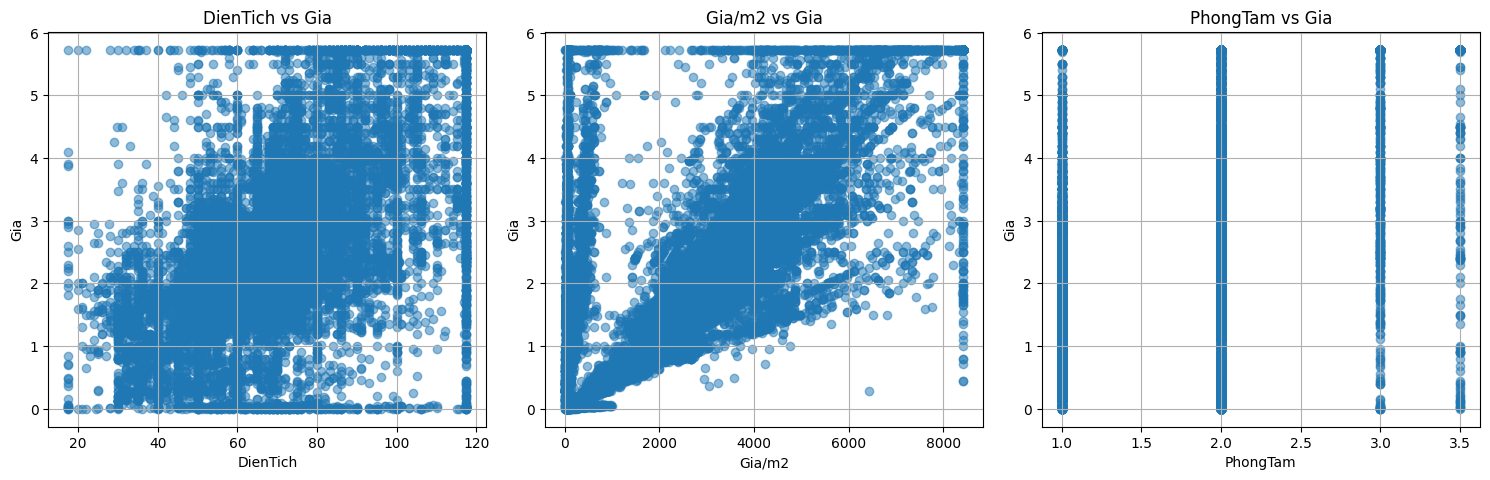

In [28]:
numeric_columns = ['DienTich', 'Gia/m2','PhongTam']

plt.figure(figsize = (15,9))
for i, col in enumerate(numeric_columns):
    plt.subplot(2, 3, i + 1)
    plt.scatter(data[col], data['Gia'], alpha=0.5)
    plt.title(f'{col} vs Gia')
    plt.xlabel(col)
    plt.ylabel('Gia')
    plt.grid(True)

plt.tight_layout()
plt.show()

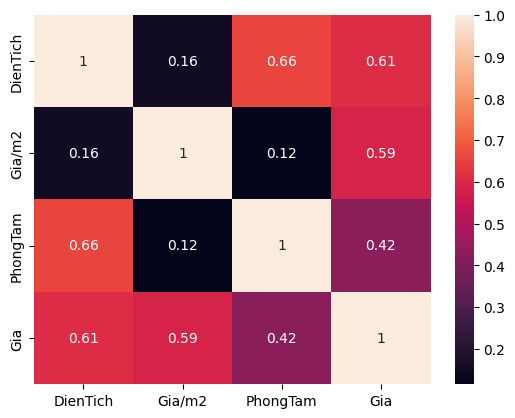

In [29]:
numeric_columns = ['DienTich', 'Gia/m2', 'PhongTam', 'Gia']
corr_matrix = data[numeric_columns].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

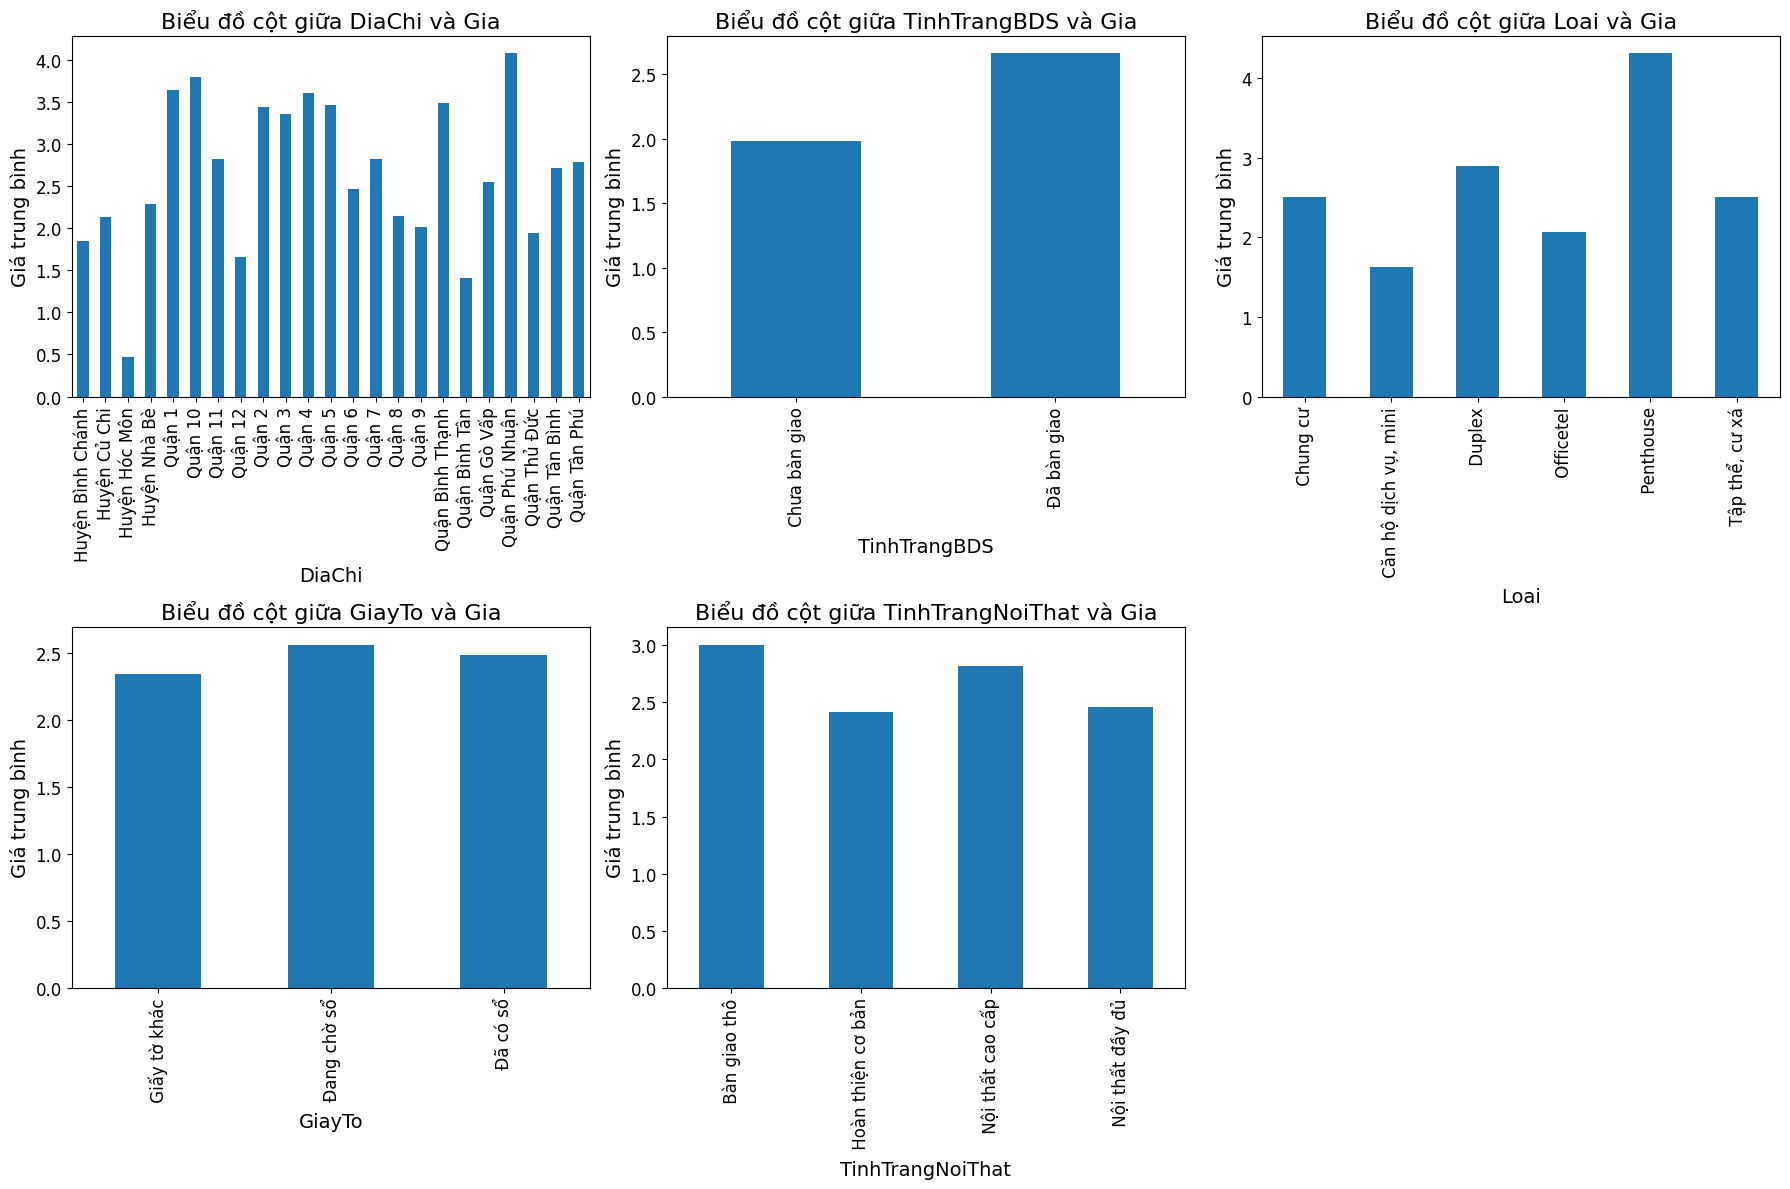

In [30]:
categorical_cols = ['DiaChi', 'TinhTrangBDS', 'Loai', 'GiayTo', 'TinhTrangNoiThat']

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

for i, col in enumerate(categorical_cols):
    mean_values = data.groupby(col)['Gia'].mean()
    mean_values.plot(kind='bar', ax=axs[i])
    axs[i].set_title(f'Biểu đồ cột giữa {col} và Gia', fontsize=16)
    axs[i].set_xlabel(col, fontsize=14)
    axs[i].set_ylabel('Giá trung bình', fontsize=14)
    axs[i].tick_params(axis='x', rotation=90, labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

# Encoding categorical data và feature scaling

In [31]:
X = data.drop(columns=['Gia'])
y = data['Gia']

In [32]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
categorical_columns = ['DiaChi', 'TinhTrangBDS', 'Loai', 'GiayTo', 'TinhTrangNoiThat']
numeric_columns = ['DienTich', 'Gia/m2', 'PhongTam']
# Mã hóa các biến phân loại bằng OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)
X_encoded = onehot_encoder.fit_transform(X[categorical_columns])

# Chuẩn hóa các biến liên tục bằng StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numeric_columns])

import numpy as np
X_processed = np.hstack((X_scaled, X_encoded))

In [33]:
X_processed

array([[-0.33710098,  0.10749105,  0.49739126, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.20709245,  1.25572059,  0.49739126, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.27121764, -1.29888275,  0.49739126, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.31801138, -0.47174757, -1.27894541, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59877382,  0.11041896,  0.49739126, ...,  0.        ,
         0.        ,  1.        ],
       [-0.43068846,  0.07869991, -1.27894541, ...,  0.        ,
         1.        ,  0.        ]])

In [34]:
encoded_feature_names = onehot_encoder.get_feature_names_out(categorical_columns)
transformed_feature_names = numeric_columns + list(encoded_feature_names)
X_processed_df = pd.DataFrame(X_processed, columns=transformed_feature_names)

In [35]:
X_processed_df.head()

,DienTich,Gia/m2,PhongTam,DiaChi_Huyện Bình Chánh,DiaChi_Huyện Củ Chi,DiaChi_Huyện Hóc Môn,DiaChi_Huyện Nhà Bè,DiaChi_Quận 1,DiaChi_Quận 10,DiaChi_Quận 11,...,Loai_ Officetel,Loai_ Penthouse,"Loai_ Tập thể, cư xá",GiayTo_ Giấy tờ khác,GiayTo_ Đang chờ sổ,GiayTo_ Đã có sổ,TinhTrangNoiThat_ Bàn giao thô,TinhTrangNoiThat_ Hoàn thiện cơ bản,TinhTrangNoiThat_ Nội thất cao cấp,TinhTrangNoiThat_ Nội thất đầy đủ
0,-0.337101,0.107491,0.497391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.207092,1.255721,0.497391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.271218,-1.298883,0.497391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.037249,1.321599,-1.278945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.645568,0.267550,0.497391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [36]:
X_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16728 entries, 0 to 16727
Data columns (total 41 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   DienTich                             16728 non-null  float64
 1   Gia/m2                               16728 non-null  float64
 2   PhongTam                             16728 non-null  float64
 3   DiaChi_Huyện Bình Chánh              16728 non-null  float64
 4   DiaChi_Huyện Củ Chi                  16728 non-null  float64
 5   DiaChi_Huyện Hóc Môn                 16728 non-null  float64
 6   DiaChi_Huyện Nhà Bè                  16728 non-null  float64
 7   DiaChi_Quận 1                        16728 non-null  float64
 8   DiaChi_Quận 10                       16728 non-null  float64
 9   DiaChi_Quận 11                       16728 non-null  float64
 10  DiaChi_Quận 12                       16728 non-null  float64
 11  DiaChi_Quận 2               

# Feature Selection

In [37]:
model = LinearRegression()
rfecv = RFECV(estimator=model, step=1, cv=KFold(5), scoring='r2')
rfecv.fit(X_processed_df, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print("Selected Features: %s" % X_processed_df.columns[rfecv.support_])
print("Feature Ranking: %s" % rfecv.ranking_)

Optimal number of features: 35
Selected Features: Index(['DienTich', 'Gia/m2', 'PhongTam', 'DiaChi_Huyện Bình Chánh',
       'DiaChi_Huyện Củ Chi', 'DiaChi_Huyện Hóc Môn', 'DiaChi_Huyện Nhà Bè',
       'DiaChi_Quận 1', 'DiaChi_Quận 10', 'DiaChi_Quận 12', 'DiaChi_Quận 2',
       'DiaChi_Quận 3', 'DiaChi_Quận 4', 'DiaChi_Quận 5', 'DiaChi_Quận 6',
       'DiaChi_Quận 8', 'DiaChi_Quận 9', 'DiaChi_Quận Bình Thạnh',
       'DiaChi_Quận Bình Tân', 'DiaChi_Quận Gò Vấp', 'DiaChi_Quận Phú Nhuận',
       'DiaChi_Quận Thủ Đức', 'DiaChi_Quận Tân Bình',
       'TinhTrangBDS_ Chưa bàn giao', 'TinhTrangBDS_ Đã bàn giao',
       'Loai_ Chung cư', 'Loai_ Căn hộ dịch vụ, mini', 'Loai_ Officetel',
       'Loai_ Penthouse', 'Loai_ Tập thể, cư xá', 'GiayTo_ Đã có sổ',
       'TinhTrangNoiThat_ Bàn giao thô', 'TinhTrangNoiThat_ Hoàn thiện cơ bản',
       'TinhTrangNoiThat_ Nội thất cao cấp',
       'TinhTrangNoiThat_ Nội thất đầy đủ'],
      dtype='object')
Feature Ranking: [1 1 1 1 1 1 1 1 1 6 1 1 1 1 1 1 4

In [38]:
X_selected = X_processed_df.loc[:, rfecv.support_]

In [39]:
X_selected.head()

,DienTich,Gia/m2,PhongTam,DiaChi_Huyện Bình Chánh,DiaChi_Huyện Củ Chi,DiaChi_Huyện Hóc Môn,DiaChi_Huyện Nhà Bè,DiaChi_Quận 1,DiaChi_Quận 10,DiaChi_Quận 12,...,Loai_ Chung cư,"Loai_ Căn hộ dịch vụ, mini",Loai_ Officetel,Loai_ Penthouse,"Loai_ Tập thể, cư xá",GiayTo_ Đã có sổ,TinhTrangNoiThat_ Bàn giao thô,TinhTrangNoiThat_ Hoàn thiện cơ bản,TinhTrangNoiThat_ Nội thất cao cấp,TinhTrangNoiThat_ Nội thất đầy đủ
0,-0.337101,0.107491,0.497391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.207092,1.255721,0.497391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.271218,-1.298883,0.497391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.037249,1.321599,-1.278945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.645568,0.267550,0.497391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# Xây dựng mô hình không dùng PCA

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [41]:
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import time

def adjusted_r2(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Hàm đánh giá mô hình
def evaluate_model(model, X, y, cv):
    mae_scores = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    mse_scores = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')

    mae = np.mean(mae_scores)
    mse = np.mean(mse_scores)
    rmse = np.sqrt(mse)
    r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)
    adj_r2 = adjusted_r2(r2, len(y), X.shape[1])

    return mae, mse, rmse, r2, std_r2, adj_r2

# Thiết lập cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)

In [42]:
svr_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}
# Sử dụng RandomizedSearchCV cho SVR
random_svr_search = RandomizedSearchCV(SVR(), param_distributions=svr_param_grid,
                                       n_iter=16,random_state=42, cv=cv, 
                                       scoring='neg_root_mean_squared_error')
random_svr_search.fit(X_selected, y)
best_svr = random_svr_search.best_estimator_

# Đánh giá mô hình SVR với siêu tham số tốt nhất
start_time = time.time()
svr_mae, svr_mse, svr_rmse, svr_r2, svr_std_r2, svr_adj_r2 = evaluate_model(best_svr, X_selected, y, cv)
svr_execution_time = time.time() - start_time

print("Best SVR Model Evaluation:")
print(f"Best Parameters: {random_svr_search.best_params_}")
print(f"MAE: {svr_mae}")
print(f"MSE: {svr_mse}")
print(f"RMSE: {svr_rmse}")
print(f"R2: {svr_r2}")
print(f"Standard Deviation of R2: {svr_std_r2}")
print(f"Adjusted R2: {svr_adj_r2}")
print(f"Execution Time: {svr_execution_time} seconds")

Best SVR Model Evaluation:
Best Parameters: {'kernel': 'rbf', 'C': 1}
MAE: 0.2978033715182872
MSE: 0.4277955156258842
RMSE: 0.6540607889377593
R2: 0.789220483298733
Standard Deviation of R2: 0.0070045789849461
Adjusted R2: 0.7887785181007612
Execution Time: 97.0693085193634 seconds


In [43]:
rf_param_grid = {
    'n_estimators': np.arange(50, 301, 50),  
    'max_depth': np.append(np.arange(10, 31, 1), None),  
    'min_samples_split': np.arange(2, 11, 2),  
    'min_samples_leaf': np.arange(1, 5)
}
# Sử dụng RandomizedSearchCV cho RandomForestRegressor
random_rf_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), 
                               param_distributions=rf_param_grid, 
                               n_iter=50, random_state=42, cv=cv, 
                               scoring='neg_root_mean_squared_error')
random_rf_search.fit(X_selected, y)
best_rf = random_rf_search.best_estimator_

# Đánh giá mô hình RandomForestRegressor với siêu tham số tốt nhất
start_time = time.time()
rf_mae, rf_mse, rf_rmse, rf_r2, rf_std_r2, rf_adj_r2 = evaluate_model(best_rf, X_selected, y, cv)
rf_execution_time = time.time() - start_time

print("Best RandomForestRegressor Model Evaluation:")
print(f"Best Parameters: {random_rf_search.best_params_}")
print(f"MAE: {rf_mae}")
print(f"MSE: {rf_mse}")
print(f"RMSE: {rf_rmse}")
print(f"R2: {rf_r2}")
print(f"Standard Deviation of R2: {rf_std_r2}")
print(f"Adjusted R2: {rf_adj_r2}")
print(f"Execution Time: {rf_execution_time} seconds")

Best RandomForestRegressor Model Evaluation:
Best Parameters: {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 22}
MAE: 0.16179765691781417
MSE: 0.28172875850023893
RMSE: 0.5307812718062299
R2: 0.8611346622226211
Standard Deviation of R2: 0.016676198981856016
Adjusted R2: 0.860843487598717
Execution Time: 212.1389398574829 seconds


In [44]:
svr_predictions = cross_val_predict(best_svr, X_selected, y, cv=cv)
rf_predictions = cross_val_predict(best_rf, X_selected, y, cv=cv)

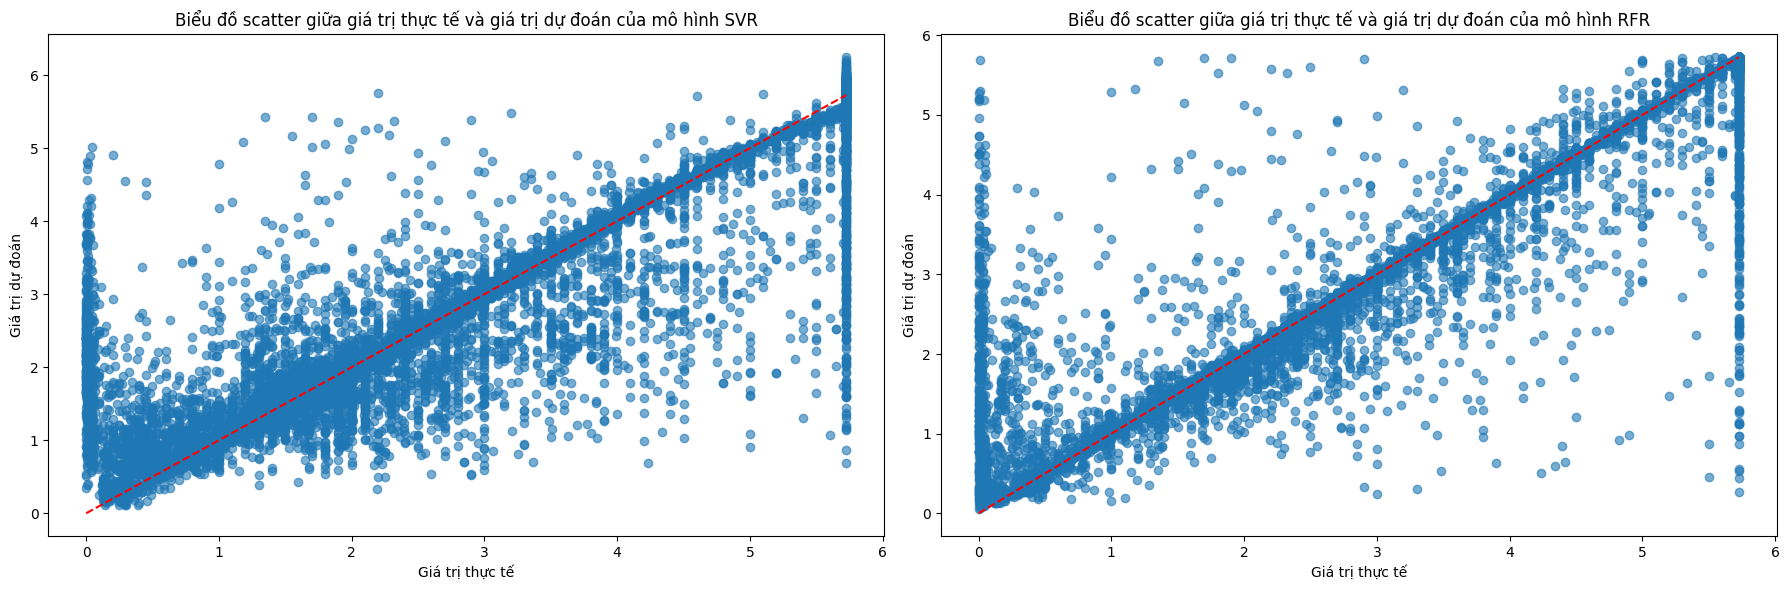

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Biểu đồ scatter cho SVR
axs[0].scatter(y, svr_predictions, alpha=0.6)
axs[0].plot([min(y), max(y)], [min(y), max(y)], 'r--')
axs[0].set_xlabel('Giá trị thực tế')
axs[0].set_ylabel('Giá trị dự đoán')
axs[0].set_title('Biểu đồ scatter giữa giá trị thực tế và giá trị dự đoán của mô hình SVR')

# Biểu đồ scatter cho RandomForestRegressor
axs[1].scatter(y, rf_predictions, alpha=0.6)
axs[1].plot([min(y), max(y)], [min(y), max(y)], 'r--')
axs[1].set_xlabel('Giá trị thực tế')
axs[1].set_ylabel('Giá trị dự đoán')
axs[1].set_title('Biểu đồ scatter giữa giá trị thực tế và giá trị dự đoán của mô hình RFR')

plt.tight_layout()
plt.show()


# PCA

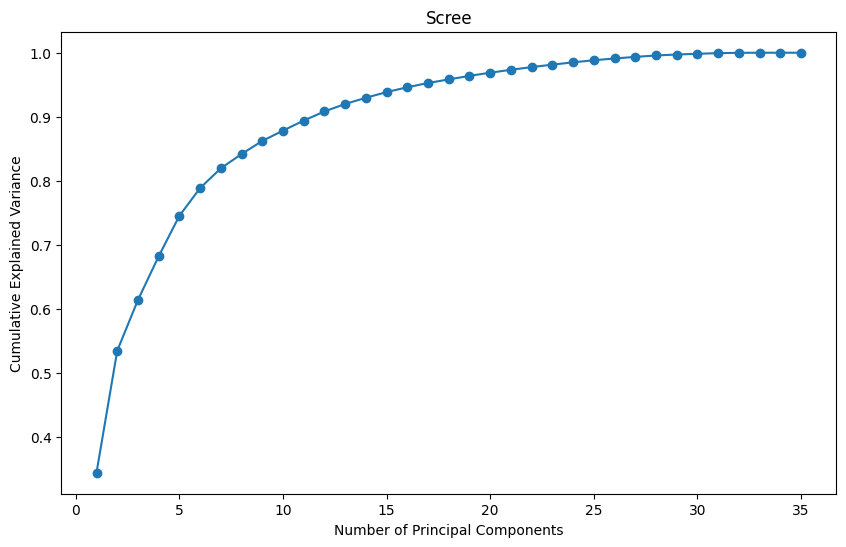

In [46]:
# PCA
pca = PCA()
pca.fit(X_selected)

# Cumulative explained variance plot
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.title('Scree')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


In [47]:
# Áp dụng PCA
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X_selected)

df_pca = pd.DataFrame(data = X_pca)

# Xây dựng mô hình dùng PCA

In [48]:
# Sử dụng RandomizedSearchCV cho SVR
random_svr_search = RandomizedSearchCV(SVR(), param_distributions=svr_param_grid,
                                       n_iter=16,random_state=42, cv=cv, 
                                       scoring='neg_root_mean_squared_error')
random_svr_search.fit(df_pca, y)
best_svr_pca = random_svr_search.best_estimator_

# Đánh giá mô hình SVR với siêu tham số tốt nhất
start_time = time.time()
svr_mae, svr_mse, svr_rmse, svr_r2, svr_std_r2, svr_adj_r2 = evaluate_model(best_svr_pca, df_pca, y, cv)
svr_execution_time = time.time() - start_time

print("Best SVR Model with PCA Evaluation:")
print(f"Best Parameters: {random_svr_search.best_params_}")
print(f"MAE: {svr_mae}")
print(f"MSE: {svr_mse}")
print(f"RMSE: {svr_rmse}")
print(f"R2: {svr_r2}")
print(f"Standard Deviation of R2: {svr_std_r2}")
print(f"Adjusted R2: {svr_adj_r2}")
print(f"Execution Time: {svr_execution_time} seconds")

Best SVR Model with PCA Evaluation:
Best Parameters: {'kernel': 'rbf', 'C': 1}
MAE: 0.30682106372090373
MSE: 0.46232927399428075
RMSE: 0.6799479935953049
R2: 0.772249224861695
Standard Deviation of R2: 0.0109824268239275
Adjusted R2: 0.7720448051855895
Execution Time: 87.40278053283691 seconds


In [49]:
# Sử dụng RandomizedSearchCV cho RandomForestRegressor
random_rf_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), 
                               param_distributions=rf_param_grid, 
                               n_iter=50, random_state=42, cv=cv, 
                               scoring='neg_root_mean_squared_error')
random_rf_search.fit(df_pca, y)
best_rf_pca = random_rf_search.best_estimator_

# Đánh giá mô hình RandomForestRegressor với siêu tham số tốt nhất
start_time = time.time()
rf_mae, rf_mse, rf_rmse, rf_r2, rf_std_r2, rf_adj_r2 = evaluate_model(best_rf_pca, df_pca, y, cv)
rf_execution_time = time.time() - start_time

print("Best RandomForestRegressor Model Evaluation:")
print(f"Best Parameters: {random_rf_search.best_params_}")
print(f"MAE: {rf_mae}")
print(f"MSE: {rf_mse}")
print(f"RMSE: {rf_rmse}")
print(f"R2: {rf_r2}")
print(f"Standard Deviation of R2: {rf_std_r2}")
print(f"Adjusted R2: {rf_adj_r2}")
print(f"Execution Time: {rf_execution_time} seconds")

Best RandomForestRegressor Model Evaluation:
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 24}
MAE: 0.2706153582150968
MSE: 0.41076371410558965
RMSE: 0.64090850681325
R2: 0.7977011517395545
Standard Deviation of R2: 0.007282053751896933
Adjusted R2: 0.7975195766603356
Execution Time: 798.7476315498352 seconds


In [50]:
svr_pca_predictions = cross_val_predict(best_svr_pca, df_pca, y, cv=cv)
rf_pca_predictions = cross_val_predict(best_rf_pca,df_pca, y, cv=cv)

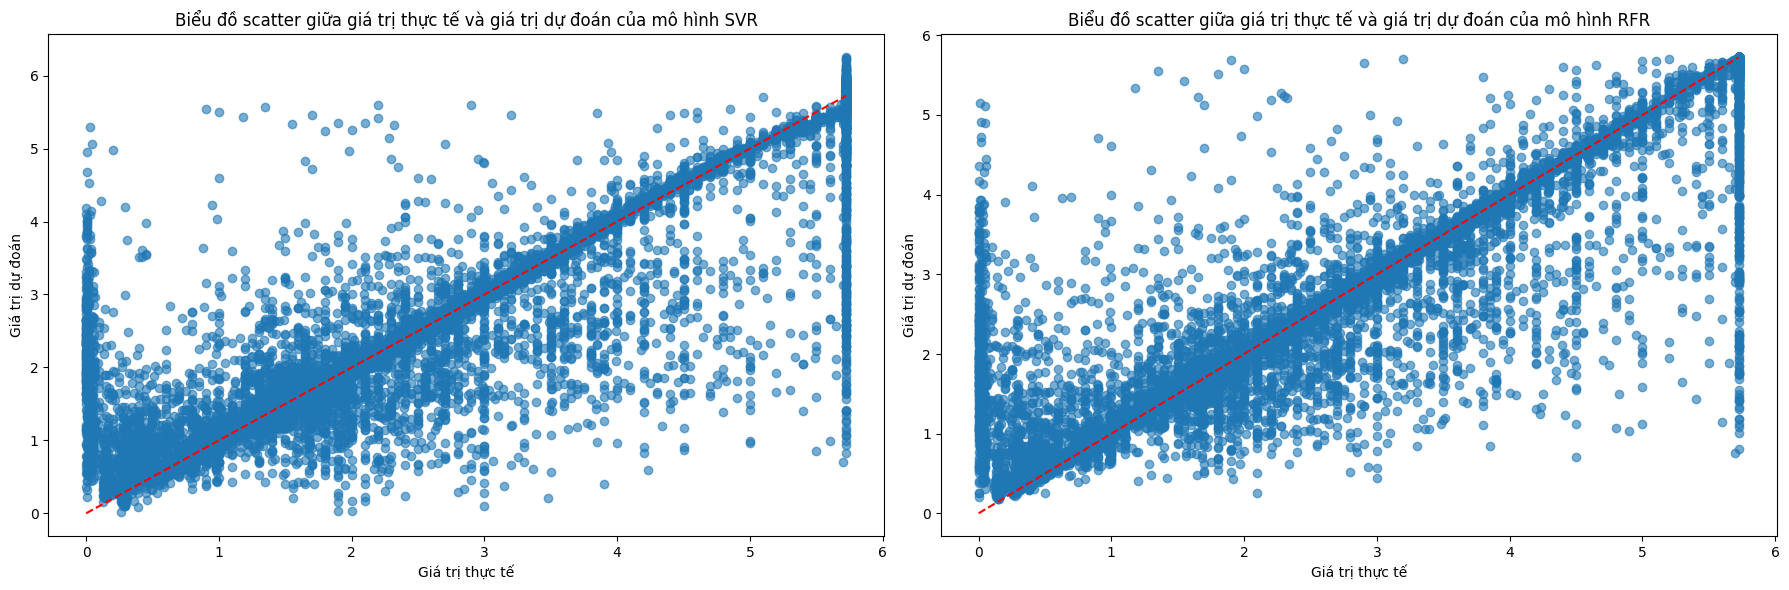

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Biểu đồ scatter cho SVR
axs[0].scatter(y, svr_pca_predictions, alpha=0.6)
axs[0].plot([min(y), max(y)], [min(y), max(y)], 'r--')
axs[0].set_xlabel('Giá trị thực tế')
axs[0].set_ylabel('Giá trị dự đoán')
axs[0].set_title('Biểu đồ scatter giữa giá trị thực tế và giá trị dự đoán của mô hình SVR')

# Biểu đồ scatter cho RandomForestRegressor
axs[1].scatter(y, rf_pca_predictions, alpha=0.6)
axs[1].plot([min(y), max(y)], [min(y), max(y)], 'r--')
axs[1].set_xlabel('Giá trị thực tế')
axs[1].set_ylabel('Giá trị dự đoán')
axs[1].set_title('Biểu đồ scatter giữa giá trị thực tế và giá trị dự đoán của mô hình RFR')

plt.tight_layout()
plt.show()
